# Data preperation step for Budget Analysis

## Initial dataset expansion trial using TMDB API

### Step 1. Making mapping by searching the function of TMDB API
There are Wikipedia IDs and Freebase IDs as an indicator for the movie on our original CMU Movie datasets. As the freebase deprecated and the wiki-data project began, both those IDs are deprecated to the current movie DB database. We failed to find an exact mapping for Freebase ID and IMDB ID. Hence, we manually made a mapper for the TMDB movie ID, by using search API with the query of movie name. The API returns the list of the movies searched by the query. To guarantee the reliability of the matching, we checked the release year of the searched movies. If there are more than 2 results that have the same released year, we only chose the case in which only one of them has exactly the same release date as our CMU dataset. Among 81,741 movie data of the original CMU dataset, 57,354 movies have matched successfully. 

In [1]:
from pathlib import Path
from tqdm import tqdm
from urllib.parse import quote
import pandas as pd
import json
import requests
import threading

You need to put your own token to re-implement.
```python
token = your_tmdb_private_token
```

In [2]:
moviesum_path = Path('MovieSummaries/')
act_col = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"]
movie_col = ["Wikipedia movie ID","Freebase movie ID","Movie name","Movie release date","Movie box office revenue","Movie runtime","Movie languages","Movie countries","Movie genres"]
character_data = pd.read_csv(moviesum_path / 'character.metadata.tsv',delimiter='\t',header=None, names = act_col)
movie_data = pd.read_csv(moviesum_path/ 'movie.metadata.tsv',delimiter='\t',header=None, names = movie_col)

In [ ]:
movie2tmdb_id = {}
movie2response = {}

In [ ]:
for i,x in tqdm(movie_data.iterrows(),total=movie_data.shape[0]):
    url = f"https://api.themoviedb.org/3/search/movie?query={url_encode_string(x['Movie name'])}&page=1"
    headers = {
        "accept": "application/json",
        "Authorization": token
    }
    response = requests.get(url, headers=headers)
    res_json = json.loads(response.text)
    if len(res_json['results']) == 0:
        continue
    movie2tmdb_id[i]=res_json['results'][0]['id']
    movie2response[i] = res_json
    movie2response[i]['Wikipedia movie ID'] = x['Wikipedia movie ID']
    if i % 1000 == 999:
        json.dump(movie2response, open('movie2res.json','w'))

In [43]:
def fetch_movie_data(row, movie2tmdb_id, movie2response, lock):
    url = f"https://api.themoviedb.org/3/search/movie?query={quote(row['Movie name'])}&page=1"
    headers = {
        "accept": "application/json",
        "Authorization": token
    }
    response = requests.get(url, headers=headers)
    try:
        res_json = json.loads(response.text)
    except json.decoder.JSONDecodeError:
        movie2response[row.name] = {}
        pass
    
    if len(res_json['results']) > 0:
        with lock:
            movie2tmdb_id[row.name] = res_json['results'][0]['id']
            movie2response[row.name] = res_json
            movie2response[row.name]['Wikipedia movie ID'] = row['Wikipedia movie ID']
            
movie2tmdb_id = {}
movie2response = {}
lock = threading.Lock()
threads = []
for i, row in tqdm(movie_data.iterrows(), total=movie_data.shape[0]):
    if row.name in movie2tmdb_id:
        continue
    t = threading.Thread(target=fetch_movie_data, args=(row, movie2tmdb_id, movie2response, lock))
    threads.append(t)
    t.start()

    if len(threads) >= 20:
        threads[0].join()
        threads.pop(0)

for t in threads:
    t.join()
    
with open('movie2res.json', 'w') as f:
    json.dump(movie2response, f)

100%|██████████| 81741/81741 [1:05:33<00:00, 20.78it/s]


In [44]:
with open('movie2res.json', 'w') as f:
    json.dump(movie2response, f)

In [87]:
wid2matched_id = {}
cnt =0
for i, row in tqdm(movie_data.iterrows(), total=movie_data.shape[0]):
    # match with Movie release date
    if row.name not in movie2response or not movie2response[row.name]:
        continue
    wid = movie2response[row.name]['Wikipedia movie ID']
    res = movie2response[row.name]['results']
    matched_year = [i for i in res if str(i.get('release_date')).split('-')[0] == str(row['Movie release date']).split('-')[0]]
    if len(matched_year) == 1:
        wid2matched_id[wid] = matched_year[0]['id']
    elif len(matched_year) > 1:
        # 1552 samples can be identified by perfect matching.
        perfect_matched = [i for i in res if str(i.get('release_date')) == str(row['Movie release date'])]
        if len(perfect_matched) == 1:
            wid2matched_id[wid] = perfect_matched[0]['id']
    # 1812 samples cannot be matched by year.

100%|██████████| 81741/81741 [00:01<00:00, 71849.04it/s]


In [88]:
with open('wikipedia_id2tmdb_id.json', 'w') as f:
    json.dump(wid2matched_id, f)

### Step 2. Get movie detail information
With 57,354 TMDB movie ids, we use movie detail API(https://developer.themoviedb.org/reference/movie-details) to obtain the information of the movie, especially the budget and revenue data. Since not all of the movie contains that data, we need to check how much data exists which contains both budget and revenue data. 
The results are as follows.
- Available budget field count: 8631
- Available revenue field count: 7760
- Both fields are available: 5756

Below is an example schema of the response object.
```json
{
  "adult": false,
  "backdrop_path": "/anSbunnEMI0TSmizqUSRACoe18l.jpg",
  "belongs_to_collection": null,
  "budget": 28000000,
  "genres": [
    {
      "id": 28,
      "name": "Action"
    },
    {
      "id": 27,
      "name": "Horror"
    },
    {
      "id": 878,
      "name": "Science Fiction"
    }
  ],
  "homepage": "http://www.theofficialjohncarpenter.com/ghost-of-mars/",
  "id": 10016,
  "imdb_id": "tt0228333",
  "original_language": "en",
  "original_title": "Ghosts of Mars",
  "overview": "In 2176, a Martian police unit is sent to pick up a highly dangerous criminal at a remote mining post. Upon arrival, the cops find the post deserted and something far more dangerous than any criminal — the original inhabitants of Mars, hellbent on getting their planet back.",
  "popularity": 22.264,
  "poster_path": "/i2zztssCIbahGES1fdfWFmDXian.jpg",
  "production_companies": [
    {
      "id": 51312,
      "logo_path": null,
      "name": "Animationwerks",
      "origin_country": ""
    },
    {
      "id": 3287,
      "logo_path": "/bz6GbCQQXGNE56LTW9dwgksW0Iw.png",
      "name": "Screen Gems",
      "origin_country": "US"
    },
    {
      "id": 23895,
      "logo_path": null,
      "name": "Storm King Productions",
      "origin_country": ""
    }
  ],
  "production_countries": [
    {
      "iso_3166_1": "US",
      "name": "United States of America"
    }
  ],
  "release_date": "2001-08-24",
  "revenue": 14010832,
  "runtime": 98,
  "spoken_languages": [
    {
      "english_name": "English",
      "iso_639_1": "en",
      "name": "English"
    }
  ],
  "status": "Released",
  "tagline": "Terror is the same on any planet.",
  "title": "Ghosts of Mars",
  "video": false,
  "vote_average": 5.125,
  "vote_count": 982
}
```

In [ ]:
def fetch_detail(tmdb_id, tmdb_id2detail, lock):
    url = f"https://api.themoviedb.org/3/movie/{tmdb_id}?language=en-US"
    headers = {
        "accept": "application/json",
        "Authorization": token
    }
    response = requests.get(url, headers=headers)
    
    with lock:
        tmdb_id2detail[tmdb_id] = response.text

tmdb_id2detail = {}
lock = threading.Lock()
threads = []
for tmdb_id in tqdm(wid2matched_id.values()):
    t = threading.Thread(target=fetch_detail, args=(tmdb_id, tmdb_id2detail, lock))
    threads.append(t)
    t.start()

    if len(threads) >= 10:
        threads[0].join()
        threads.pop(0)

for t in threads:
    t.join()

In [ ]:
with open('tmdb_id2detail.json', 'w') as f:
    json.dump(tmdb_id2detail, f)

In [152]:
budgets = []
revenues = []
valid_details = {}
for k,v in tmdb_id2detail.items():
    budget = json.loads(v)['budget']
    revenue = json.loads(v)['revenue']
    budgets.append(budget)
    revenues.append(revenue)
    if budget > 0 and revenue > 0:
        valid_details[k]=json.loads(v)

In [137]:
budgets_valid = [x for x in budgets if x > 0]
revenues_valid = [x for x in revenues if x > 0]

In [147]:
len(budgets_valid), len(revenues_valid), len(list(valid_details.values()))

(8631, 7760, 5756)

### 3. The decision to expand to the entire TMDB dataset
We concluded 5.7K data point is too sparse to analyze the career of the actor. Even if we focus on the most-appeared actors, more than 60% of his/her movies won't have budget and revenue data. In order to address this issue, we decided to get all movie information from TMDB. According to the latest database dump(https://developer.themoviedb.org/docs/daily-id-exports) on Nov 14th, there are total of 863,167 movies, which is 15 times bigger than our original dataset. 
```bash
python download_data.py
```
This code is used to obtain our dataset, which is available in this link (link to Google Drive). 34 hours computation of full CPU load is required to finish the dataset construction. 

You can find the full dataset here (https://drive.google.com/file/d/1zQZ7XkwJooR3HEysPbLp5ndOnOkm1reC/view?usp=sharing), with the EPFL account.

(values need to be changed after processing) Among a total of 863,082 datasets, 12,487 data have both budgets and revenues fields. 45,155 data have budget field.

In [15]:
import pandas as pd
import json
import os

data_path = 'tmdb_resources/tmdb_id2detail.json'
if not os.path.exists(data_path):
    tmdb_id2detail = {}
else:
    tmdb_id2detail = json.load(open(data_path,'r'))

budgets = []
revenues = []
valid_details = {}
for k,v in tmdb_id2detail.items():
    budget = json.loads(v)['budget']
    revenue = json.loads(v)['revenue']
    budgets.append(budget)
    revenues.append(revenue)
    if budget > 0 and revenue > 0:
        valid_details[k]=json.loads(v)
        
budgets_valid = [x for x in budgets if x > 0]
revenues_valid = [x for x in revenues if x > 0]

print(len(budgets_valid), len(revenues_valid), len(list(valid_details.values())), len(list(tmdb_id2detail.keys())))

45155 18903 12487 863082


### 4. Get credit data

For the movies have one of budget or revenue fields, we received the credit data by using movie/credits API(https://developer.themoviedb.org/reference/movie-credits) on TMDB. This response contains information of the actors and crews, including their role. Same as detail API, download_data.py contains the execution code for downloading credit data.
Below is an example schema of the return object of the API.

You can access the data with EPFL account via this link [https://drive.google.com/file/d/1-LLtFBB7MRRUZ1vp0skLvaX91z88xSaJ/view?usp=sharing]
There are total 51,568 movies and 365,150 individual actors.

```json
{
  "id": 10016,
  "cast": [
    {
      "adult": false,
      "gender": 1,
      "id": 57395,
      "known_for_department": "Acting",
      "name": "Natasha Henstridge",
      "original_name": "Natasha Henstridge",
      "popularity": 49.626,
      "profile_path": "/lfRFm3MLOGPtaDHWTstoQfKAyLM.jpg",
      "cast_id": 10,
      "character": "Lt. Melanie Ballard",
      "credit_id": "52fe43089251416c75000d71",
      "order": 0
    },
    {
      "adult": false,
      "gender": 2,
      "id": 1368878,
      "known_for_department": "Crew",
      "name": "Damon Caro",
      "original_name": "Damon Caro",
      "popularity": 2.995,
      "profile_path": "/7uw119r2YmsQYIduvSSP3hxIT94.jpg",
      "cast_id": 67,
      "character": "Shape-Male Intern (uncredited)",
      "credit_id": "5ff26ade1108a800418987bb",
      "order": 25
    },
  ]
}
```

In [16]:
data_path = 'tmdb_resources/tmdb_id2credit.json'
tmdb_id2credit = json.load(open(data_path,'r')) if os.path.exists(data_path) else {}

In [17]:
from collections import defaultdict
from tqdm import tqdm

actor_cnt = defaultdict(int)
for k,v in tqdm(tmdb_id2credit.items()):
    res = json.loads(v)['cast']
    for x in res:
        if x['known_for_department'] == 'Acting':
            actor_cnt[x['id']] += 1

100%|██████████| 51568/51568 [00:01<00:00, 27270.01it/s]


365150


(array([2.65316e+05, 4.55500e+04, 2.91130e+04, 1.03030e+04, 7.96600e+03,
        4.20700e+03, 1.72800e+03, 7.36000e+02, 2.15000e+02, 1.60000e+01]),
 array([0.        , 0.47791235, 0.9558247 , 1.43373705, 1.9116494 ,
        2.38956175, 2.8674741 , 3.34538645, 3.82329879, 4.30121114,
        4.77912349]),
 <BarContainer object of 10 artists>)

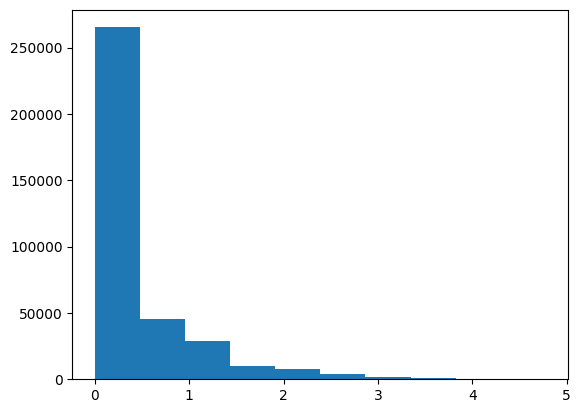

In [18]:
import matplotlib.pyplot as plt
import math
print(len(list(actor_cnt.keys())))
plt.hist([math.log(v) for v in actor_cnt.values()])

### Summary of data processing
We decided that the CMU movie dataset was not large enough to test our hypothesis, so we expanded the data with recently released data from the TMDB. We have 863K movie data, 12.4K budget and revenue data, and 365K actor data.